In [196]:
import torch
from torch import nn, optim
import numpy as np
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from sklearn.datasets import make_swiss_roll
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pickle as pkl
import random
from sklearn.model_selection import train_test_split

In [197]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using {device} device.")

Using cuda device.


In [198]:
torch.cuda.empty_cache()


In [199]:
# The encoder

class Autoencoder(nn.Module):

    def __init__(self, in_shape, enc_shape):
        super(Autoencoder, self).__init__()
        
        self.encode = nn.Sequential(
            nn.Linear(in_shape, 512),
            nn.ReLU(True),
            #nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(True),
            #nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(True),
            #nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, enc_shape)
        )
        
        self.decode = nn.Sequential(
            nn.BatchNorm1d(enc_shape),
            nn.Linear(enc_shape, 64),
            nn.ReLU(True),
            #nn.Dropout(0.2),
            nn.Linear(64, 128),
            nn.ReLU(True),
            #nn.Dropout(0.2),
            nn.Linear(128, 256),
            nn.ReLU(True),
            #nn.Dropout(0.2),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, in_shape)
        )
        
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

In [200]:
# Function to train encoder

def train(model, error, optimizer, n_epochs, batch_size, x, plot):
    model.train()
    indices = [i for i in range(x.shape[0])]
    errors = []
    
    for epoch in range(1, n_epochs + 1):
        
        random.shuffle(indices)
        batches = [i for i in range(0, len(indices), batch_size)]

        for i in range(len(batches) - 1):
            
            batch_x = x[indices[batches[i]:batches[i+1]]]
            optimizer.zero_grad()
            output = model(batch_x)
            loss = error(output, batch_x)
            loss.backward()
            optimizer.step()
            errors.append(loss.cpu().detach().numpy())
            
        if epoch % int(0.1*n_epochs) == 0:
            print(f'epoch {epoch} \t Loss: {loss.item():.4g}')
    
    if plot:
        plt.plot(errors)

In [201]:
with open('data_dict.pkl', 'rb') as f:
    loaded_dict = pkl.load(f)

In [202]:
X = np.concatenate([v for v in loaded_dict.values()])

"""scaler = StandardScaler().fit(X)
X = scaler.transform(X)"""

X = X[0:-1:2,:]
X = torch.Tensor(X).double().to(device)

In [203]:
# function to split data into train and test sets
def train_test_split(X, test_size):
    
    indices = [i for i in range(X.shape[0])]
    random.shuffle(indices)
    
    test_indices = indices[:int(test_size*len(indices))]
    train_indices = indices[int(test_size*len(indices)):]

    trainX = X[train_indices,:]
    testX = X[test_indices,:]
    
    return trainX, testX
    
    

In [204]:
trainX, testX = train_test_split(X, 0.25)

In [205]:
# Define dimensions
enc_shape = 3
inc_shape = X.shape[1]

In [206]:
# Define model and params
encoder = Autoencoder(in_shape=inc_shape, enc_shape=enc_shape).double().to(device)
error = nn.L1Loss()
optimizer = optim.Adam(encoder.parameters(), lr=1e-3)

epoch 1 	 Loss: 1.794
epoch 2 	 Loss: 1.788
epoch 3 	 Loss: 1.61
epoch 4 	 Loss: 1.71
epoch 5 	 Loss: 1.938
epoch 6 	 Loss: 1.795
epoch 7 	 Loss: 1.893
epoch 8 	 Loss: 1.819
epoch 9 	 Loss: 1.86
epoch 10 	 Loss: 1.704


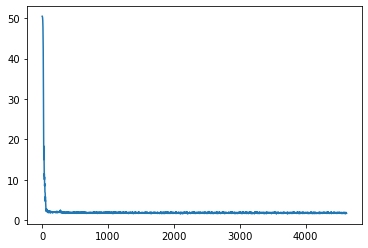

In [207]:
# Train encoder
train(encoder, error, optimizer, 10, 32, trainX, plot=True)

In [208]:
with torch.no_grad():
    encoded = encoder.encode(testX)
    decoded = encoder.decode(encoded)
    err = error(decoded, testX).item()
    print(f"Error on test set: {err}")
    E = decoded - testX
    enc = encoded.cpu().detach().numpy()
    dec = decoded.cpu().detach().numpy()

Error on test set: 1.7684028959193199


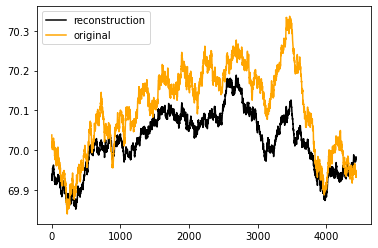

In [210]:
# Plotting running means of atom positions for reconstruction and original
n = 20
conv = 500
w = np.convolve(dec[:,n], np.ones(conv)/conv, mode='valid')
q = np.convolve(testX.cpu().detach().numpy()[:,n], np.ones(conv)/conv, mode='valid')

plt.plot(w, color='k', label="reconstruction")
plt.plot(q, color='orange', label="original")
plt.legend()